# Autoencoder for GAN Iter. 5.5

Changes:
1. Contractive autoencoder produced poor results so the contractive loss function was removed.
2. Denoising autoencoder produced poor results so process of adding noise to the data was removed.
3. Changed the way the data was being fed to the autoencoder.
4. Previously the entire dataset for each airfoil was being fed to the AE all at once. In reality, an engineer shouldn't need an airfoil to operate at specific conditions for such a large range of Re. Instead of giving the AE a huge chunk to replicate the dataset will be broken into 10 ranges of Re that will be used to train the AE.
5. Each chunk spans 22 Re and contains 7 different properties. The original dataset included 10 properties but 3 were removed for reasons explained below. The shape of the chunks are 22x202x7. An additional column was added to the beginning of the dataset to include the reynolds number used to find the data in the row. The Reynolds number was in tens of millions to avoid problems with data magnitude.
6. 3 properties were removed from the dataset, the lift to drag ratio (LD), aerodynamic center (AC) and center of pressure (CP) were removed due to frequent outliers and much larger values than the other properties. The lift to drag ratio can be estimated by looking at the coefficient of lift and coefficient of drag, and the aerodynamic center and center of pressure can be looked into further after preliminary design.


### Import TensorFlow and other libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras import losses

# models used
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential

# layers used in models
from tensorflow.keras.layers import InputLayer
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Reshape
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import Conv3D
from tensorflow.keras.layers import Conv3DTranspose
#from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import BatchNormalization

tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

### Load the Dataset, remove unwanted data, and reorganize into chunks

In [2]:
# Load Dataset
P_data = np.load("D:\\Non Windows Stuff\\HPC Research\\Airfoil_Performance_Data.npy")
P_data = P_data[:,:,:,0:7]

# Reorganize data set into chunks rather than huge 10 layer sheets
rows = 22
cNum = 10
NewData = np.zeros((1584*cNum,rows,202,7))
ReNum = np.linspace(np.zeros((1,1,7)),2.1*np.ones((1,1,7)),22,axis=1).reshape((rows,1,7),order='F')
DataTypes = list(range(1,7))
for a in range(1584):
    for c in range(0,10):
        ind = c*11
        Chunk = P_data[a,ind:ind+rows,:,:]
        ReCol = ReNum*0.15+0.1+(c*1.1*0.15) #in tens of millions 
        NewData[cNum*a+c,:,:] = np.hstack((ReCol,Chunk))

NewData = NewData.reshape(NewData.shape[0],NewData.shape[1],NewData.shape[2],NewData.shape[3],1)

del P_data

IndexNums = list(range(NewData.shape[0]))
np.random.shuffle(IndexNums)
TrainData = NewData[IndexNums[0:1584*7]]
TestData = NewData[IndexNums[1584*7:1584*10]]
del NewData

print('Training Data Shape:')
print(TrainData.shape)
print('\nTest Data Shape:')
print(TestData.shape)

Training Data Shape:
(11088, 22, 202, 7, 1)

Test Data Shape:
(4752, 22, 202, 7, 1)


### Define Autoencoder

Encoder Layers
1. **Input Layer** ---- (22,202,7,1)
2. **Convolution 1** ---- (None,22,202,7) --> (None,22,100,7)
  1. 32 filters
  2. 1x4x1 kernel
  3. 1x2x1 stride
  4. Sigmoid acitvation
  5. No padding
  6. Batch Normalization
3. **Convolution 2** ---- (None,22,100,7) --> (None,22,50,7)
  1. 64 filters
  2. 1x3x1 kernel
  3. 1x2x1 stride
  4. Sigmoid acitvation
  5. Same padding
  6. Batch Normalization
4. **Convolution 3** ---- (None,22,50,7) --> (None,22,24,7)
  1. 128 filters
  2. 1x4x1 kernel
  3. 1x2x1 stride
  4. Sigmoid acitvation
  5. No padding
  6. Batch Normalization
5. **Convolution 4** ---- (None,22,24,7) --> (None,10,10,7)
  1. 256 filters
  2. 4x6x1 kernel
  3. 2x2x1 stride
  4. Sigmoid acitvation
  5. No padding
  6. Batch Normalization
6. **Convolution 5** ---- (None,10,10,7) --> (None,10,10,1)
  1. 512 filters
  2. 1x1x7 kernel
  3. 1x1x1 stride
  4. Sigmoid acitvation
  5. No padding
  6. Batch Normalization
7. **Flatten** into 51200 neurons
8. **Fully connected layer**

Decoder Layers are reverse of the encoder layers
  

In [3]:
latent_dim = 64 

class Autoencoder(Model):
  def __init__(self, latent_dim):
    super(Autoencoder, self).__init__()
    self.latent_dim = latent_dim
    F = [32, 64, 128, 256, 512]
    #F = F[::-1]
    
    #================ ENCODER ================
    self.encoder = Sequential()
    
    # Input layer
    self.encoder.add(InputLayer(input_shape=(22,202,7,1)))
    
    # ~~~~~ Convolution 1 ~~~~~
    self.encoder.add(Conv3D(F[0],(1,4,1),(1,2,1),activation='sigmoid',padding='valid'))
    #self.encoder.add(LeakyReLU(alpha=0.2))
    self.encoder.add(BatchNormalization(axis=-1))
    
    # ~~~~~ Convolution 2 ~~~~~
    self.encoder.add(Conv3D(F[1],(1,3,1),(1,2,1),activation='sigmoid',padding='same'))
    #self.encoder.add(LeakyReLU(alpha=0.2))
    self.encoder.add(BatchNormalization(axis=-1))
    
    # ~~~~~ Convolution 3 ~~~~~
    self.encoder.add(Conv3D(F[2],(1,4,1),(1,2,1),activation='sigmoid',padding='valid'))
    #self.encoder.add(LeakyReLU(alpha=0.2))
    self.encoder.add(BatchNormalization(axis=-1))
    
    # ~~~~~ Convolution 4 ~~~~~
    self.encoder.add(Conv3D(F[3],(4,6,1),(2,2,1),activation='sigmoid',padding='valid'))
    #self.encoder.add(LeakyReLU(alpha=0.2))
    self.encoder.add(BatchNormalization(axis=-1))
    
    # ~~~~~ Convolution 5 ~~~~~
    self.encoder.add(Conv3D(F[4],(1,1,7),(1,1,1),activation='sigmoid',padding='valid'))
    #self.encoder.add(LeakyReLU(alpha=0.2))
    self.encoder.add(BatchNormalization(axis=-1))
    
    
    # Prepare output
    self.encoder.add(Flatten())
    outShape = 10*10
    self.encoder.add(Dense(outShape))
    
    #================ DECODER ================
    self.decoder = Sequential()
    
    # Input layer
    self.decoder.add(InputLayer(input_shape=(100,)))
    self.decoder.add(Dense(F[4]*outShape))
    self.decoder.add(Reshape([10,10,1,F[4]]))
    
    # ~~~~~ Deconvolution 1 ~~~~~
    self.decoder.add(Conv3DTranspose(F[3],(1,1,7),(1,1,1),activation='sigmoid',padding='valid'))
    #self.decoder.add(LeakyReLU(alpha=0.2))
    self.decoder.add(BatchNormalization(axis=-1))
    
    # ~~~~~ Deconvolution 2 ~~~~~
    self.decoder.add(Conv3DTranspose(F[2],(4,6,1),(2,2,1),activation='sigmoid',padding='valid'))
    #self.decoder.add(LeakyReLU(alpha=0.2))
    self.decoder.add(BatchNormalization(axis=-1))
    
    # ~~~~~ Deconvolution 3 ~~~~~
    self.decoder.add(Conv3DTranspose(F[1],(1,4,1),(1,2,1),activation='sigmoid',padding='valid'))
    #self.decoder.add(LeakyReLU(alpha=0.2))
    self.decoder.add(BatchNormalization(axis=-1))
    
    # ~~~~~ Deconvolution 4 ~~~~~
    self.decoder.add(Conv3DTranspose(F[0],(1,3,1),(1,2,1),activation='sigmoid',padding='same',output_padding=(0,1,0)))
    #self.decoder.add(LeakyReLU(alpha=0.2))
    self.decoder.add(BatchNormalization(axis=-1))
    
    # ~~~~~ Deconvolution 5 ~~~~~
    self.decoder.add(Conv3DTranspose(1,(1,4,1),(1,2,1),activation='sigmoid',padding='valid'))
    #self.decoder.add(LeakyReLU(alpha=0.2))
    self.decoder.add(BatchNormalization(axis=-1))
    

  def call(self, x):
      encoded = self.encoder(x)
      decoded = self.decoder(encoded)
      return decoded

# compile the model, MSE is the standard loss function for autoencoders
AE = Autoencoder(latent_dim)
AE.compile(optimizer='adam', loss=losses.MeanSquaredError())
print('=======  ENCODER SUMMARY  =======')
AE.encoder.summary()
print('\n\n=======  DECODER SUMMARY  =======')
AE.decoder.summary()

=======  ENCODER SUMMARY  =======
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d (Conv3D)              (None, 22, 100, 7, 32)    160       
_________________________________________________________________
batch_normalization (BatchNo (None, 22, 100, 7, 32)    128       
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 22, 50, 7, 64)     6208      
_________________________________________________________________
batch_normalization_1 (Batch (None, 22, 50, 7, 64)     256       
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 22, 24, 7, 128)    32896     
_________________________________________________________________
batch_normalization_2 (Batch (None, 22, 24, 7, 128)    512       
_________________________________________________________________
conv3d_3 (Conv3D)     

### Train the model

In [4]:
# Train the model with x_test as input and the target output
AE.fit(TrainData, TrainData, epochs=10, shuffle=True, validation_data=(TestData, TestData))

Epoch 1/10
347/347 [==============================] - 48s 127ms/step - loss: 0.1032 - val_loss: 0.2404
Epoch 2/10
347/347 [==============================] - 44s 126ms/step - loss: 0.0065 - val_loss: 0.0259
Epoch 3/10
347/347 [==============================] - 44s 126ms/step - loss: 0.0039 - val_loss: 0.0047
Epoch 4/10
347/347 [==============================] - 44s 128ms/step - loss: 0.0034 - val_loss: 0.0040
Epoch 5/10
347/347 [==============================] - 44s 126ms/step - loss: 0.0028 - val_loss: 0.0074
Epoch 6/10
347/347 [==============================] - 44s 126ms/step - loss: 0.0025 - val_loss: 0.0085
Epoch 7/10
347/347 [==============================] - 44s 126ms/step - loss: 0.0032 - val_loss: 0.0107
Epoch 8/10
347/347 [==============================] - 44s 126ms/step - loss: 0.0022 - val_loss: 0.0123
Epoch 9/10
347/347 [==============================] - 44s 127ms/step - loss: 0.0021 - val_loss: 0.0256
Epoch 10/10
347/347 [==============================] - 44s 126ms/step - l

### Encode a test set

In [7]:
# Test the model by encoding and decoding the test data

encoded_imgs = AE.encoder(TestData[0:12]).numpy()
decoded_imgs = AE.decoder(encoded_imgs).numpy()

print(decoded_imgs.shape)

(12, 22, 202, 7, 1)


### Plot the test set

The images represent only the first 3 properties of the data set.
  
<span style="color:red">Red</span> - Cofficient of Lift
 
<span style="color:blue">Blue</span> - Cofficient of Drag
 
<span style="color:green">Green</span> - Cofficient of Moment about the quarter chord

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

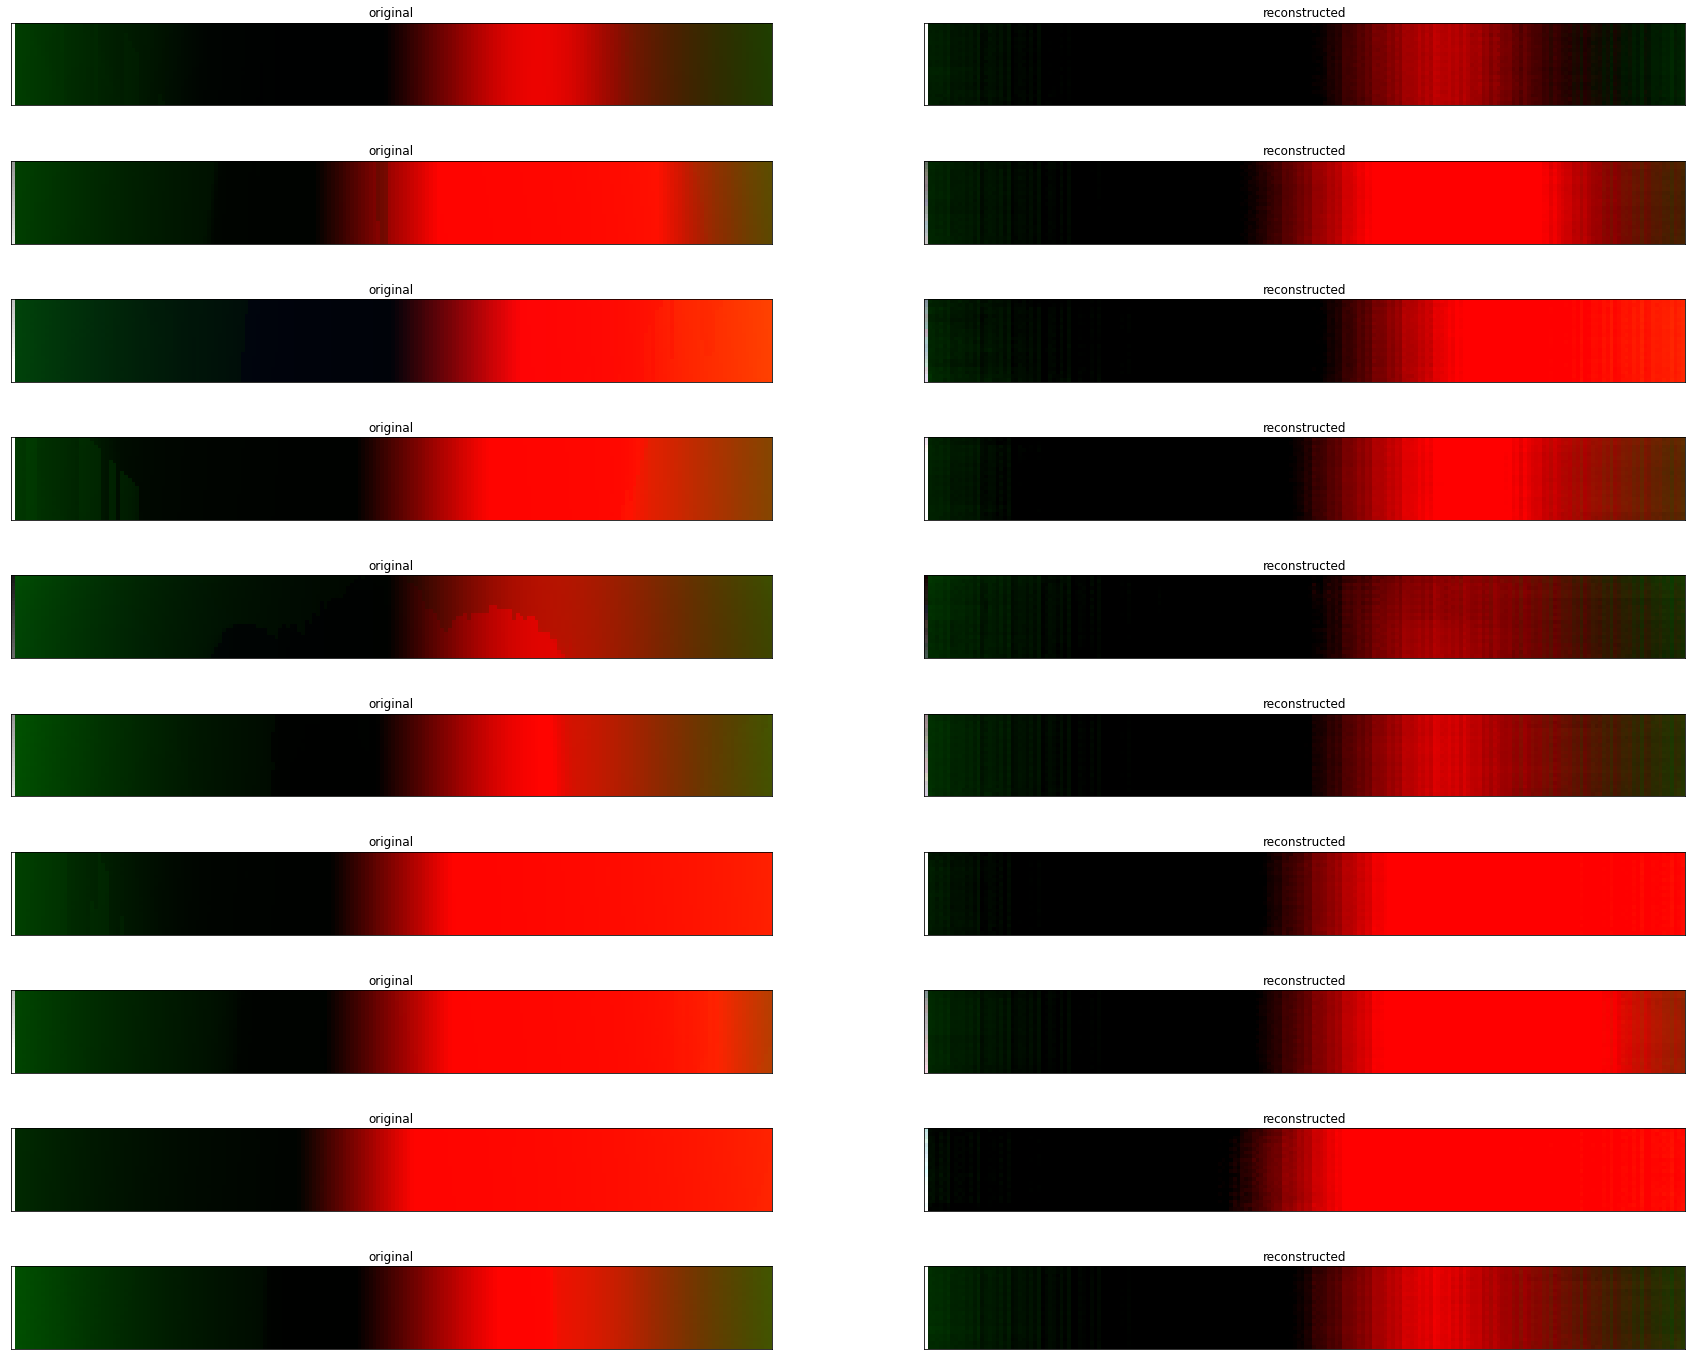

In [9]:
#%% Plot them (not really images but they should look similar) (only used CL, CD, and CM as R, G, and B

n = 10
plt.figure(figsize=(30, 25))
r = 10
c = 2
for i in range(n):
  # display original
  ax = plt.subplot(r, c, 2*i + 1)
  plt.imshow(TestData[i,:,:,0:3].reshape(22,202,3))
  plt.title("original")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  # display reconstruction
  ax = plt.subplot(r, c, 2 * (i + 1) )
  plt.imshow(decoded_imgs[i,:,:,0:3].reshape(22,202,3))
  plt.title("reconstructed")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
plt.show()

The output above is not perfect but was run with only 10 epochs for simplicity.